In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display 

In [2]:
import numpy as np                  
import pandas as pd                
import matplotlib.pyplot as plt         
import seaborn as sns                 

# Анализ бизнес-показателей Яндекс.Афиша

Будучи стажером отдела маркетинговой аналитики Яндекс.Афиши. Имея в наличии данные Яндекс.Афиши с июня 2017 по конец мая 2018 года, нужно помочь маркетологам снизить расходы, отказавшись от невыгодных источников трафика, и перераспределить бюджет.

Имеющиеся данны:
- лог сервера с данными о посещениях сайта Яндекс.Афиши;
- выгрузка всех заказов за этот период;
- статистика рекламных расходов.

Необходимо изучить:
- как клиенты пользуются сервисом;
- когда делают первые покупки на сайте;
- сколько денег приносит компании каждый клиент;
- когда расходы на привлечение клиента окупаются.

## Загрузка и подготовка данных

### Загрузка данных из файлов

Выгрузим имеющиеся данные из файлов и представим в виде датафрэймов:

In [3]:
visits = pd.read_csv('visits_log.csv')
display(visits.head())
orders = pd.read_csv('orders_log.csv')
display(orders.head())
costs = pd.read_csv('costs.csv')
costs.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Итак, на данном шаге были сформированны 3 датафрейма. В первом хранится информация обо всех логах сервера с посещениями сайта, датой и временем посещения, id пользователя, категорией устройства пользователя, а также идентификатором источника перехода на сайт. Второй датафрэйм содержит сведения о заказах: id пользователя, дата и время заказа и стоимость. И наконец третий датафрэм с данными о маркетинговых расходах: дата проведения компании, расходы и идентификатор рекламного источника.

### Подготовка данных к анализу

Произведем подготовку данных, изменив названия столбцов, проверив наличие дубликатов и пропусков, а также приведем данные в столбцах к нужным типам: 

In [4]:
visits.info()
print()
print(f'Количество дубликатов в visits: {visits.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

Количество дубликатов в visits: 0


In [5]:
orders.info()
print()
print(f'Количество дубликатов в orders: {orders.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB

Количество дубликатов в orders: 0


In [6]:
costs.info()
print()
print(f'Количество дубликатов в costs: {costs.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

Количество дубликатов в costs: 0


In [7]:
visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], axis='columns', inplace=True)
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis='columns', inplace=True)     
costs.set_axis(['source_id', 'date', 'costs'], axis='columns', inplace=True)

In [8]:
visits['end_ts'] =  pd.to_datetime(visits['end_ts'])
visits['start_ts'] =  pd.to_datetime(visits['start_ts'])
visits.info()
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()
costs['date'] = pd.to_datetime(costs['date'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
date         2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


В добавок ко всему, стоит рассмотреть данные в столбце 'revenue' датафрэйма orders:

In [9]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [10]:
print(f'Количество нулевых значений в столбце revenue: {len(orders[orders["revenue"] == 0])}')

Количество нулевых значений в столбце revenue: 51


Покупка которая не принесла дохода. Выглядит странно, похоже это ошибка в данных, возможно что рассчет в данных сделках происходил по каким-то особым условиям(акция с уникальными условиями или безналичный расчет за бонусные баллы), в любом случае данные покупки не принесли прибыль с продажи продукта и учет их в относительных или абсолютных показателях может внести небольшие искажения. Поскольку таких покупок немного, избавимся от них.

In [11]:
orders = orders.query('revenue > 0')

Так же в столбцах с данными о начале и окончании пользовательской сессии есть ошибки. Очевдно время окончания посещения сайта должно быть неменьше времени его начала, обратное просто невозможно, устраним данные недочеты:

In [12]:
visits.loc[visits['start_ts'] > visits['end_ts']]

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


In [13]:
visits = visits.drop(visits.loc[visits['start_ts'] > visits['end_ts']].index).reset_index(drop=True)

In [14]:
visits.loc[visits['start_ts'] > visits['end_ts']]

,device,end_ts,source_id,start_ts,uid


Подготовка произведена: дубликаты и пропуски отсутствуют, данные приведены к нужным типам, а названия столбцов в датафрэймах более удобные чем исходные. И теперь все данных готовы к анализу. 

## Расчет метрик и построение графиков

Необходимо расчитать продуктовые, маркетинговые и метрики электронной коммерции. А также отобразить на графиках их изменения во времени и сформулировать выводы.

### Продуктовые метрики

Используя лог сервера с информацие о посещения сайта, исследуем поведение пользователей при использовании сервиса Яндекс.Афиша. Для этого рассчитаем продуктовые метрики и их изменение во времени, что позволит оценить популярность сервиса, трафик притока новых клиентов, коэффициент удержания и др.

#### Расчет DAU, WAU и MAU. Вычисление средних значения этих метрик за весь период. Отображение изменения метрик во времени на графиках.

Изучим пользовательску активность. Для этого рассчитаем DAU, WAU и MAU, показатели отображающие количество уникальных пользователей в различные временных интервалы:

In [15]:
visits['start_ts_year'] = visits['start_ts'].dt.year
visits['start_ts_month'] = visits['start_ts'].dt.month
visits['start_ts_week'] = visits['start_ts'].dt.week
visits['start_ts_date'] = visits['start_ts'].dt.date
visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [16]:
DAU = visits.groupby('start_ts_date').agg({'uid': 'nunique'})           #создание агрегированных таблиц
WAU = visits.groupby(['start_ts_year', 'start_ts_week']).agg({'uid': 'nunique'})
MAU = visits.groupby(['start_ts_year', 'start_ts_month']).agg({'uid':'nunique'})

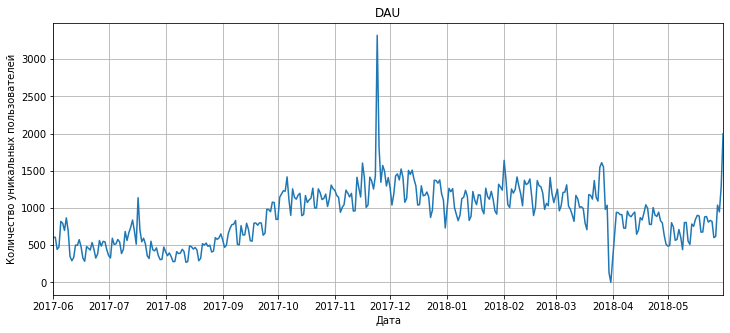

Среднее значение DAU за весь период: 908



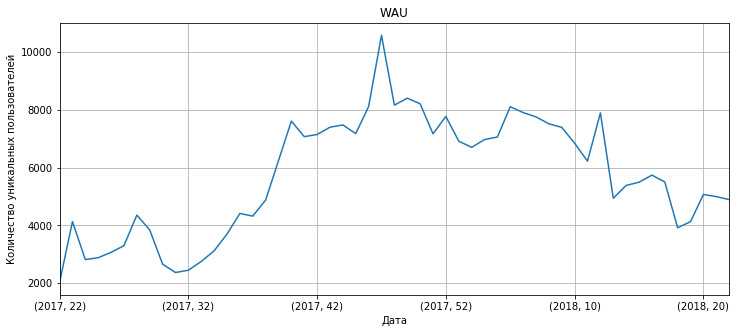

Среднее значение WAU за весь период: 5716



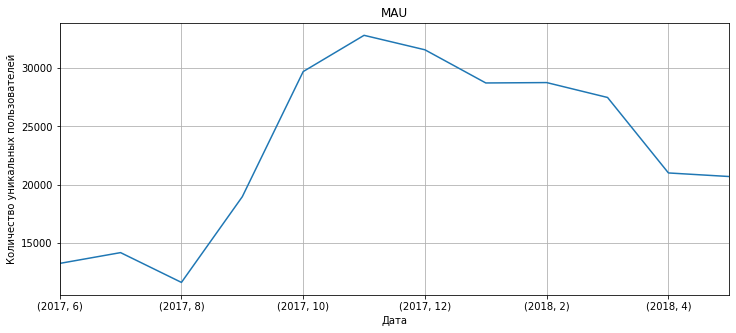

Среднее значение MAU за весь период: 23228



In [17]:
metrics = [DAU, WAU, MAU]              
title = ['DAU', 'WAU', 'MAU']
counter = 0
for i in metrics:
    i.plot(grid=True, figsize=(12, 5), legend=False)
    plt.title(title[counter])
    plt.xlabel('Дата')
    plt.ylabel('Количество уникальных пользователей')
    plt.show()
    print(f'Среднее значение {title[counter]} за весь период: {int(i.mean().round())}')
    print()
    counter += 1

#### Среднее количество визитов пользователей сервиса в день.

Выясним сколько раз за день пользователи в среднем заходят на сайт, для этого сгруппируем данные по дате и определим количество визитов за весь день и количество пользователей совершивших эти визиты. Впоследствии разделим количество визитов на количество пользователей:

In [18]:
count_visits_per_day = visits.groupby('start_ts_date').agg({'uid': ['count', 'nunique']}) #группировка по дням
count_visits_per_day['average_visits_count'] = (count_visits_per_day[('uid', 'count')] /
                                                count_visits_per_day[('uid', 'nunique')]) #подсчет среднего количества визитов
print(f'Среднее количество визитов в день: {count_visits_per_day["average_visits_count"].mean().round(2)}')

Среднее количество визитов в день: 1.08


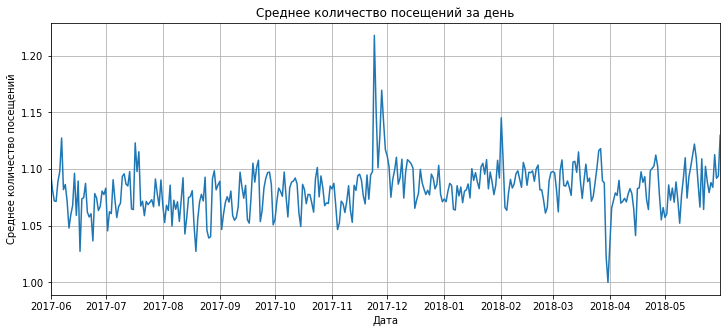

In [19]:
count_visits_per_day['average_visits_count'].plot(grid=True, figsize=(12, 5), legend=False)
plt.title('Среднее количество посещений за день')
plt.xlabel('Дата')
plt.ylabel('Среднее количество посещений')
plt.show()

#### Исследование времени нахождения пользователей на сайте. Продолжительность типичной пользовательской сессии.

Ярким отображение заинтересованности пользователей в сервисе является время нахожения на сайте. Поэтому стоит изучить время нахождения на сайта и рассчитать продолжительность типичной пользовательской сессии.

In [20]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds 
visits['session_duration_sec'].mean().round()                                    

643.0

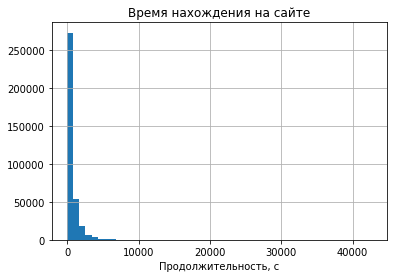

In [21]:
visits['session_duration_sec'].hist(bins=50)                               
plt.title('Время нахождения на сайте')
plt.xlabel('Продолжительность, с')
plt.show()

Распределение значений продолжительности пользовательских сессий имеет далеко не нормальных характер, большая часть значений находится в первой корзине, поэтому при расчета средней характеристики нельзя ссылаться на среднее или медиану, в данном случае воспользуемся модой:

In [22]:
print(f'Продолжительность типичной пользовательской сессиии: {int(visits["session_duration_sec"].mode())} секунд.')

Продолжительность типичной пользовательской сессиии: 60 секунд.


#### Расчет Retention Rate с помощью когортного анализа

Retention Rate является самой важной продуктовой метрикой. С ее помощью можно оценить какое количество изначального числа пользователей продолжает пользоваться продуктом, что позволяет напрямую оценивать популярность сервиса.

In [23]:
first_visit = visits.groupby('uid')['start_ts'].min()                 
first_visit.name = 'first_visit'
visits = visits.join(first_visit, on='uid')
first_visit.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_visit, dtype: datetime64[ns]

In [24]:
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-01


In [25]:
visits['lifetime'] = visits['visit_month'] - visits['first_visit_month']     
visits['lifetime'] = visits['lifetime'] / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit,first_visit_month,visit_month,lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


In [26]:
cohorts = visits.groupby(['first_visit_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_visit_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
initial_users_count.head()                                           

,first_visit_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [27]:
cohorts = cohorts.merge(initial_users_count, on='first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']             
cohorts.head()

,first_visit_month,lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [28]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].astype('str')
retention_pivot = (
    cohorts.pivot_table(index='first_visit_month',
    columns='lifetime', values='retention', aggfunc='mean')
)
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


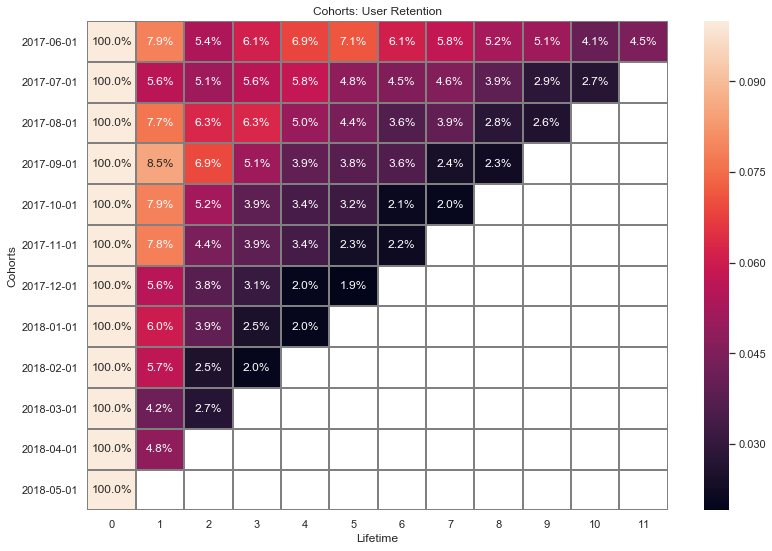

In [29]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.1)
plt.xlabel('Lifetime')
plt.ylabel('Cohorts')
plt.show()

In [30]:
average_RR = retention_pivot[1].mean().round(3) * 100
print(f'Средний Retention Rate на второй месяц жизни когорт: {average_RR}%')

Средний Retention Rate на второй месяц жизни когорт: 6.5%


#### Вывод

Рассчитанные продуктовые метрики говорят нам, что в целом сервис весьма популярен. Средние значения DAU, WAU и MAU говорят о том, что имеется достаточно большое количество новых посетителей сайта. Каждый пользователь совершает в среднем 1.08 посещений сервиса в день, а продолжительность типичной пользовательской сессии составляет 60 секунд. В общем сервис постоянно привлекает все новых и новых клиентов. Но все же показатель удержания клиентов не очень велик, лишь небольшое количество людей посетивших сайт вернется снова и возможно совершит покупку. Поэтому маркетологам следует увеличивать показатели метрики Retention Rate.

### Метрики электронной коммерции

Важно исследовать продажи сервиса, чтобы иметь представление о прибыльности бизнесса. Используя данные из таблце с заказами, расчитаем различные метрики электронной комерции и на их основе сделаем выводы.

#### Исследование среднего времени с момента первого посещения сайта до совершения покупки.

Расчитаем сколько в среднем времени уходи на то, чтобы посетитель сайта превратился в покупателя:

In [31]:
buyers = orders.groupby('uid')['buy_ts'].min()  

In [32]:
buyers_visits = visits.query('uid in @buyers.index')  
buyers_visits = buyers_visits.groupby('uid')['first_visit'].min().reset_index()
buyer_new = buyers_visits.merge(buyers, on='uid')
buyer_new['time_to_buy'] = buyer_new['buy_ts'] - buyer_new['first_visit']
buyer_new.head()

,uid,first_visit,buy_ts,time_to_buy
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


In [33]:
buyer_new['sec'] = buyer_new['time_to_buy'].dt.total_seconds()
buyer_new.head()

,uid,first_visit,buy_ts,time_to_buy,sec
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106 days 23:02:00,9241320.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0 days 01:19:00,4740.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0 days 19:44:00,71040.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00,0.0


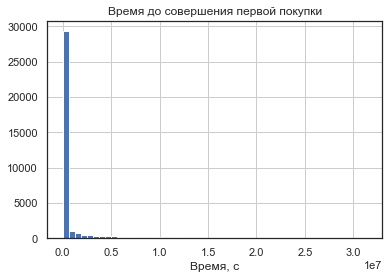

In [34]:
buyer_new['sec'].hist(bins=50)
plt.title('Время до совершения первой покупки')
plt.xlabel('Время, с')
plt.show()

In [35]:
buyer_new['sec'].describe()

count    3.650900e+04
mean     1.461642e+06
std      4.069015e+06
min      0.000000e+00
25%      2.400000e+02
50%      9.600000e+02
75%      1.741200e+05
max      3.138864e+07
Name: sec, dtype: float64

In [36]:
buyer_new['sec'].mode()

0    60.0
dtype: float64

In [37]:
print(f'Среднее время до совершения покупки: {int(buyer_new["sec"].mode())} секунд.')

Среднее время до совершения покупки: 60 секунд.


#### Расчет среднего количества покупок на одного покупателя за определенный период.

Оценим каково среднее значение количества покупок одного покупателя за некоторое время. Возьмем период в 1 квартал, и вычислим сколько в среднем покупок делает один человек в квартал:

In [38]:
buys = orders.copy()      
buys['year'] = buys['buy_ts'].dt.year
buys['quarter'] = buys['buy_ts'].dt.quarter
buys_new = buys.groupby(['year', 'quarter']).agg({'uid':['count', 'nunique']})
buys_new['average_count_buys'] = buys_new[('uid', 'count')] / buys_new[('uid', 'nunique')]
buys_new

uid         average_count_buys
              count nunique                   
year quarter                                  
2017 2         2353    2022           1.163699
     3         7548    5999           1.258210
     4        17527   13440           1.304092
2018 1        15326   11808           1.297934
     2         7610    6128           1.241841

In [39]:
q_buys = buys_new['average_count_buys'].mean().round(3)
print(f'Среднее количество покупок на одного покупателя за квартал: {q_buys}')

Среднее количество покупок на одного покупателя за квартал: 1.253


#### Расчет среднего чека, с применением группировки по времени совершения покупки.

Теперь рассмотрим каково среднее значение суммы одного заказа, то есть расчитаем средний чек одной покупки:

In [40]:
buys['month'] = buys['buy_ts'].dt.month
buys_gr = buys.groupby(['year', 'month']).agg({'revenue':['sum', 'count']})
buys_gr['average_check'] = buys_gr[('revenue', 'sum')] / buys_gr[('revenue', 'count')]
buys_gr

revenue       average_check
                 sum count              
year month                              
2017 6       9557.49  2353      4.061832
     7      12539.47  2362      5.308836
     8       8758.78  1803      4.857892
     9      18345.51  3383      5.422852
     10     27987.70  5677      4.930016
     11     27069.93  5644      4.796231
     12     36388.60  6206      5.863455
2018 1      19417.13  4721      4.112927
     2      25560.54  5280      4.841011
     3      28834.59  5325      5.414946
     4      16858.06  3265      5.163265
     5      20735.98  4344      4.773476
     6          3.42     1      3.420000

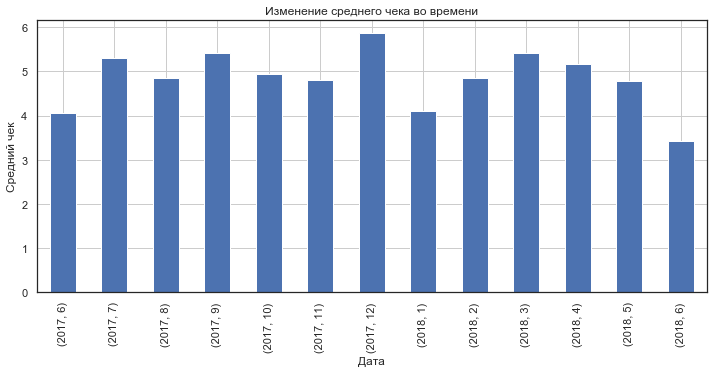

In [41]:
buys_gr['average_check'].plot(kind='bar', grid=True, figsize=(12, 5))  
plt.title('Изменение среднего чека во времени')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

In [42]:
buys_check = buys_gr['average_check'].mean().round(3)
print(f'Средний чек одного покупателя: {buys_check}')

Средний чек одного покупателя: 4.844


#### Расчет средниего LTV по когортам за 6 месяцев, при маржинальности сервиса — 100%

Показатель LTV один из замых важных, он показывает валовую прибиль одного покупателя, и является основополагающим при оценки прибыльности бизнеса.

In [43]:
orders['buy_ts_month'] = orders['buy_ts'].astype('datetime64[M]')        
first_orders = orders.groupby('uid').agg({'buy_ts_month':'min'}).reset_index()
first_orders.columns = ['uid', 'first_buy_ts_month']
first_orders.head()

,uid,first_buy_ts_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


In [44]:
orders_extended = pd.merge(orders, first_orders, on='uid')
orders_extended.head()

,buy_ts,revenue,uid,buy_ts_month,first_buy_ts_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [45]:
cohorts = (
    orders_extended.groupby(['first_buy_ts_month', 'buy_ts_month'])       
    .agg({'revenue':'sum'}).reset_index()
)
cohorts.head()

,first_buy_ts_month,buy_ts_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [46]:
cohort_size = first_orders.groupby('first_buy_ts_month').agg({'uid':'nunique'}).reset_index()
cohort_size.columns = ['first_buy_ts_month', 'n_buyers']           
cohort_size

,first_buy_ts_month,n_buyers
0,2017-06-01,2022
1,2017-07-01,1922
2,2017-08-01,1369
3,2017-09-01,2579
4,2017-10-01,4340
5,2017-11-01,4078
6,2017-12-01,4380
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3534


In [47]:
cohorts = cohorts.merge(cohort_size, on='first_buy_ts_month')
cohorts.head()

,first_buy_ts_month,buy_ts_month,revenue,n_buyers
0,2017-06-01,2017-06-01,9557.49,2022
1,2017-06-01,2017-07-01,981.82,2022
2,2017-06-01,2017-08-01,885.34,2022
3,2017-06-01,2017-09-01,1931.30,2022
4,2017-06-01,2017-10-01,2068.58,2022


In [48]:
cohorts['age'] = (cohorts['buy_ts_month'] - cohorts['first_buy_ts_month']) / np.timedelta64(1, 'M')
cohorts['age'] = cohorts['age'].round().astype('int')                              
cohorts['ltv'] = cohorts['revenue'] / cohorts['n_buyers']               
cohorts.head()

,first_buy_ts_month,buy_ts_month,revenue,n_buyers,age,ltv
0,2017-06-01,2017-06-01,9557.49,2022,0,4.726751
1,2017-06-01,2017-07-01,981.82,2022,1,0.485569
2,2017-06-01,2017-08-01,885.34,2022,2,0.437854
3,2017-06-01,2017-09-01,1931.30,2022,3,0.955143
4,2017-06-01,2017-10-01,2068.58,2022,4,1.023037


In [49]:
cohorts['first_buy_ts_month'] = cohorts['first_buy_ts_month'].astype('str')
ltv_pivot = cohorts.pivot_table(index='first_buy_ts_month', columns='age', values='ltv', aggfunc='mean')
ltv_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.726751,0.485569,0.437854,0.955143,1.023037,0.735865,0.950198,0.581879,0.553487,0.606088,0.571543,0.256983
2017-07-01,6.013345,0.335385,0.623855,0.359162,0.176883,0.156129,0.120271,0.141894,0.161316,0.147222,0.155754,NaN
2017-08-01,5.280373,0.472337,0.458817,0.391563,0.494412,0.283747,0.210818,0.405303,0.292425,0.188115,NaN,NaN
2017-09-01,5.648907,1.118453,0.519938,3.978876,0.400869,0.647569,0.702152,0.243339,0.184149,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.159358,0.398808,0.199703,0.325191,0.147903,0.053919,0.115012,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.742434,0.260553,0.925731,1.066005,0.313144,0.338279,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


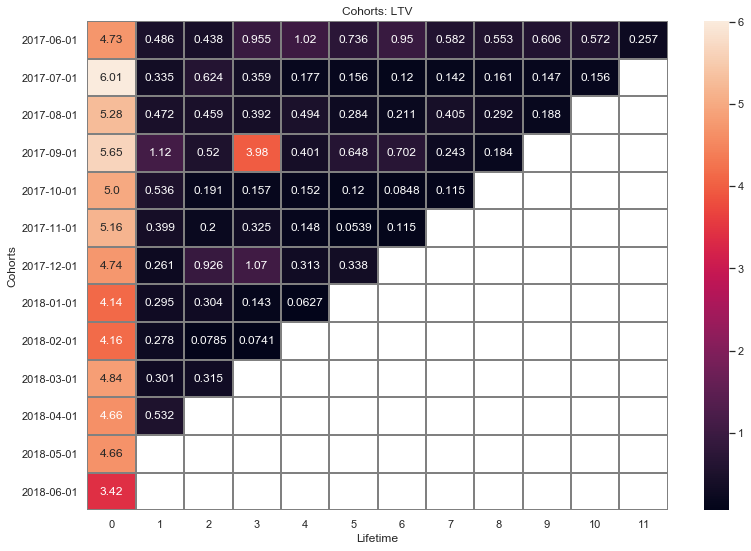

In [50]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: LTV')
sns.heatmap(ltv_pivot, annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.xlabel('Lifetime')
plt.ylabel('Cohorts')
plt.show()

In [51]:
halfyear = ltv_pivot[ltv_pivot[5].notna()].index                           
cohorts_halfyear = cohorts[cohorts['first_buy_ts_month'].isin(halfyear)]
ltv_search = (
    cohorts_halfyear.pivot_table(index='first_buy_ts_month', columns='age', values='ltv', aggfunc='sum')
)
ltv_search

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.726751,0.485569,0.437854,0.955143,1.023037,0.735865,0.950198,0.581879,0.553487,0.606088,0.571543,0.256983
2017-07-01,6.013345,0.335385,0.623855,0.359162,0.176883,0.156129,0.120271,0.141894,0.161316,0.147222,0.155754,NaN
2017-08-01,5.280373,0.472337,0.458817,0.391563,0.494412,0.283747,0.210818,0.405303,0.292425,0.188115,NaN,NaN
2017-09-01,5.648907,1.118453,0.519938,3.978876,0.400869,0.647569,0.702152,0.243339,0.184149,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.159358,0.398808,0.199703,0.325191,0.147903,0.053919,0.115012,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.742434,0.260553,0.925731,1.066005,0.313144,0.338279,NaN,NaN,NaN,NaN,NaN,NaN


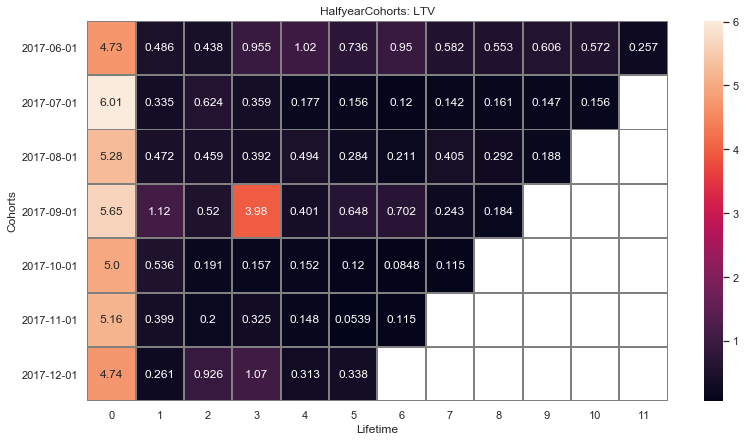

In [52]:
sns.set(style='white')                      
plt.figure(figsize=(13, 7))
plt.title('HalfyearCohorts: LTV')
sns.heatmap(ltv_search, annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.xlabel('Lifetime')
plt.ylabel('Cohorts')
plt.show()

In [53]:
ltv_search.cumsum(axis=1)                 #суммарный LTV за некотороый период жизни

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_ts_month,,,,,,,,,,,,
2017-06-01,4.726751,5.212319,5.650173,6.605317,7.628353,8.364219,9.314416,9.896296,10.449782,11.055870,11.627413,11.884397
2017-07-01,6.013345,6.348730,6.972586,7.331748,7.508632,7.664761,7.785031,7.926925,8.088241,8.235463,8.391217,NaN
2017-08-01,5.280373,5.752710,6.211527,6.603090,7.097502,7.381249,7.592067,7.997370,8.289795,8.477911,NaN,NaN
2017-09-01,5.648907,6.767359,7.287297,11.266173,11.667041,12.314610,13.016762,13.260101,13.444250,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.159358,5.558166,5.757869,6.083060,6.230964,6.284882,6.399895,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.742434,5.002986,5.928717,6.994721,7.307865,7.646144,NaN,NaN,NaN,NaN,NaN,NaN


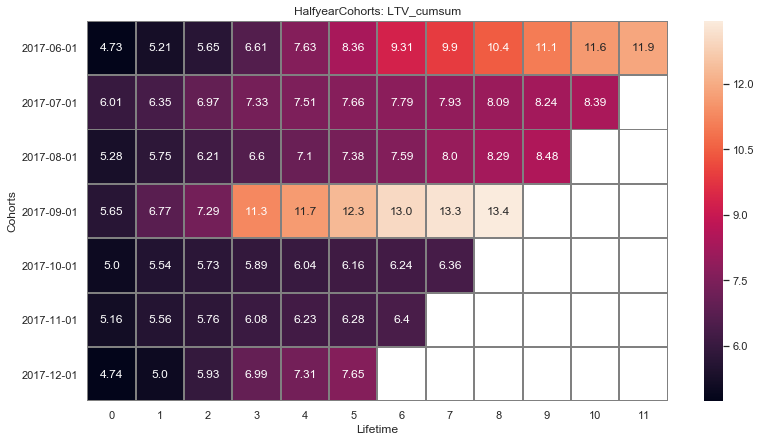

In [54]:
sns.set(style='white')                  
plt.figure(figsize=(13, 7))
plt.title('HalfyearCohorts: LTV_cumsum')
sns.heatmap(ltv_search.cumsum(axis=1), annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.xlabel('Lifetime')
plt.ylabel('Cohorts')
plt.show()

In [55]:
print(f'Средний LTV по когортам за 6 месяцев: {ltv_search.cumsum(axis=1)[5].mean().round(2)}')

Средний LTV по когортам за 6 месяцев: 7.97


In [56]:
print(f'Количество покупателей: {orders["uid"].nunique()}')

Количество покупателей: 36509


#### Вывод

Изучив данные о продажах и расчитав коммерческие метрики, стало возможным дать оценку продаваемости сервиса. Согласно расчетам с момента первого посещения сайта пользователем и его первой покупки в среднем проходит 16 дней и 22 часа, это очень долго, покупатели колеблятся нерешаясь сделать заказ сразу, видимо что-то их отпугивает. Среднее количество заказов для одного пользователя, например в квартал составляет 1.253 этот папаметр, так же оставляет желать лучшего. А вот размер среднего чека приятно радует - 4.844, весьма ценные продажи. И показатель пожизненой прибыли одного клиента так же придает оптимизма, но трудно говорить об окупаемости не зная о затратах на привлечение всех этих покупателей.

### Маркетинговые метрики

Чтобы придти к выводу о прибыльности или убыточности бизнеса, имея данные метрик прибыли, необходимо расчитать маркетинговые метрики. Оценив и сравнив расходы на привлечение клиентов с прибылью от этих клиентов, можно будет точно сказать прибылен бизнес или надо что-то менять. 

Так как один пользователь мог посетить сайт с разных источников, необходимо выделить для него "главный", пусть это будет источник, с которого он посетил сервис впервые:

In [57]:
main_source = visits[visits['start_ts'] == visits['first_visit']] 
print(len(main_source))
visits['uid'].nunique()

228170


228169

В полученом срезе количество строк на 1 больше чем число уникальных пользователей. Нужно найти ошибку:

In [58]:
err = main_source.groupby('uid').count()
err = err[err['end_ts'] > 1].index
main_source[main_source['uid'].isin(err)]

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit,first_visit_month,visit_month,lifetime
44992,touch,2018-03-16 08:57:00,1,2018-03-16 08:55:00,1981020429381477763,2018,3,11,2018-03-16,120,2018-03-16 08:55:00,2018-03-01,2018-03-01,0
47066,touch,2018-03-16 08:55:00,1,2018-03-16 08:55:00,1981020429381477763,2018,3,11,2018-03-16,0,2018-03-16 08:55:00,2018-03-01,2018-03-01,0


Ошибка в том, что один и тот же визит пользователя был зарегестрирован дважды. Не будем учитыва строку с визитом в 0 секунд в дальнейших расчетах:

In [59]:
main_source = main_source.drop(index=47066).reset_index()
len(main_source)

228169

In [60]:
main_source = main_source[['uid', 'source_id']]
main_source.columns = ['uid', 'main_source_id']
visits = visits.merge(main_source, on='uid')
visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_year,start_ts_month,start_ts_week,start_ts_date,session_duration_sec,first_visit,first_visit_month,visit_month,lifetime,main_source_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0,4
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0,5
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2,4
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0,4


####  Подсчет общей суммы расходов на маркетинг. Распределение трат по источникам.

Прежде всего стоит начать с вычисленя расходов на маркетинг. Определим и визуализируем затраты на продивижение для всех набора данных, а также в разрезе по источникам:

In [61]:
costs['month'] = costs['date'].astype('datetime64[M]') 

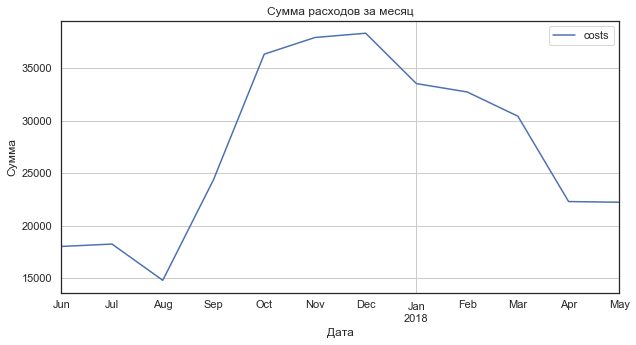

In [62]:
costs.groupby('month').agg({'costs':'sum'}).plot(grid=True, figsize=(10, 5))      
plt.title('Сумма расходов за месяц')                       
plt.xlabel('Дата')
plt.ylabel('Сумма')
plt.show()

Теперь расчитаем распределение расходов за все время в разрезе по источникам:

In [63]:
source_costs = costs.groupby(['source_id', 'month']).agg({'costs':'sum'}).reset_index()
source_costs.columns = ['source_id', 'month', 'costs_sum']
costs = costs.merge(source_costs, on=['source_id','month'])                 #добавление расходов в канале за каждый месяц 
costs.head()

,source_id,date,costs,month,costs_sum
0,1,2017-06-01,75.20,2017-06-01,1125.61
1,1,2017-06-02,62.25,2017-06-01,1125.61
2,1,2017-06-03,36.53,2017-06-01,1125.61
3,1,2017-06-04,55.00,2017-06-01,1125.61
4,1,2017-06-05,57.08,2017-06-01,1125.61


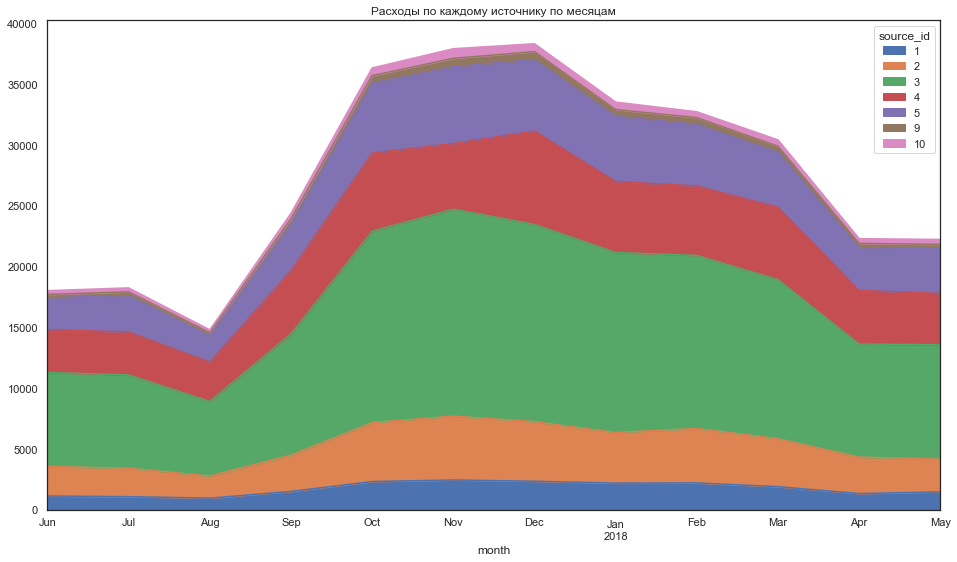

In [64]:
(
    costs.pivot_table(index='month', columns='source_id', values='costs', aggfunc='sum')
    .plot.area(figsize=(16,9), title='Расходы по каждому источнику по месяцам')
)
plt.show()

Итак, на полученном графике можно увидеть как распределялись ежемесячные расходы на маркетинг в каждом канале продвижения. Самые малопродвигаемые каналы продвижения под номером 9 и 10. А самый затратный источник под номером 3.

#### Расчет среднего CAC на одного покупателя для всего проекта и для каждого источника трафика.

Последний шаг перед определением ROMI - подсчет метрики CAC, она даст точное значение суммы затраченной для привлечения одного клиента. Необходимо расчитать CAC для всего проекта и для каждого источника трафика:

In [65]:
n_buyers = orders_extended.groupby('first_buy_ts_month').agg({'uid':'nunique'}).reset_index()      
n_buyers.rename(columns={'first_buy_ts_month':'month', 'uid':'n_buyers'}, inplace=True)
month_costs = costs.groupby('month').agg({'costs':'sum'}).reset_index()               
CAC = month_costs.merge(n_buyers, on='month')
CAC['CAC'] = CAC['costs'] / CAC['n_buyers']
CAC

,month,costs,n_buyers,CAC
0,2017-06-01,18015.00,2022,8.909496
1,2017-07-01,18240.59,1922,9.490421
2,2017-08-01,14790.54,1369,10.803901
3,2017-09-01,24368.91,2579,9.448976
4,2017-10-01,36322.88,4340,8.369327
5,2017-11-01,37907.88,4078,9.295704
6,2017-12-01,38315.35,4380,8.747797
7,2018-01-01,33518.52,3373,9.937302
8,2018-02-01,32723.03,3651,8.962758
9,2018-03-01,30415.27,3534,8.606471


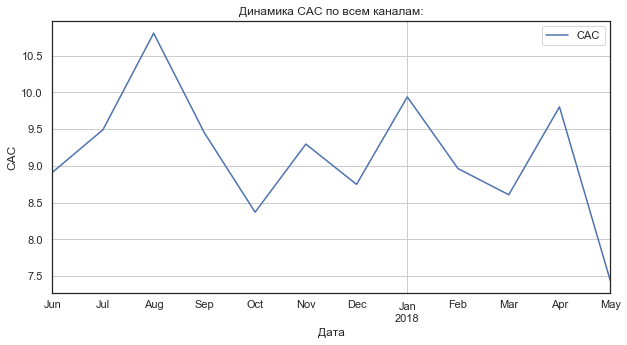

In [66]:
CAC.plot(x='month', y='CAC', grid=True, figsize=(10, 5))     
plt.title('Динамика CAC по всем каналам:')     
plt.xlabel('Дата')
plt.ylabel('CAC')
plt.show()

Теперь определим изменение метрики САС на одного покупателя для каждого источника трафика:

In [67]:
m_s_i = visits.groupby('uid')['main_source_id'].min()      
orders_extended = orders_extended.merge(m_s_i, on='uid')

In [68]:
buyers_daily = orders_extended.groupby(['main_source_id', 'first_buy_ts_month']).agg({'uid': 'nunique'}).reset_index()
buyers_daily.rename(
    columns={'main_source_id':'source_id', 'first_buy_ts_month':'month',        
             'uid': 'n_buyers_source'}, inplace=True)
costs = costs.merge(buyers_daily, on=['source_id', 'month'])                         
costs['source_CAC'] = costs['costs_sum'] / costs['n_buyers_source']                
costs.head()

,source_id,date,costs,month,costs_sum,n_buyers_source,source_CAC
0,1,2017-06-01,75.20,2017-06-01,1125.61,190,5.924263
1,1,2017-06-02,62.25,2017-06-01,1125.61,190,5.924263
2,1,2017-06-03,36.53,2017-06-01,1125.61,190,5.924263
3,1,2017-06-04,55.00,2017-06-01,1125.61,190,5.924263
4,1,2017-06-05,57.08,2017-06-01,1125.61,190,5.924263


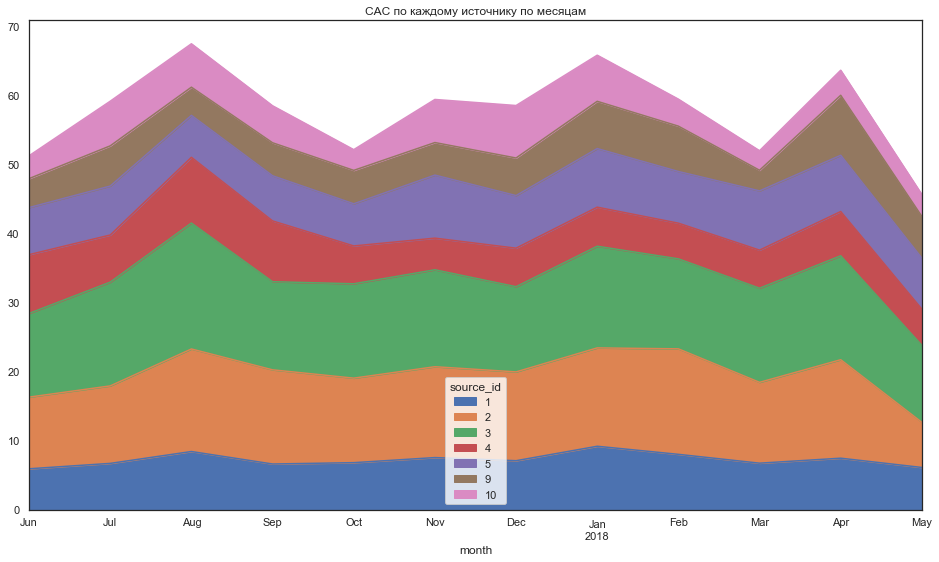

In [69]:
(
    costs.pivot_table(index='month', columns='source_id', values='source_CAC', aggfunc='mean')
    .plot.area(figsize=(16,9), title='CAC по каждому источнику по месяцам')
)
plt.show()

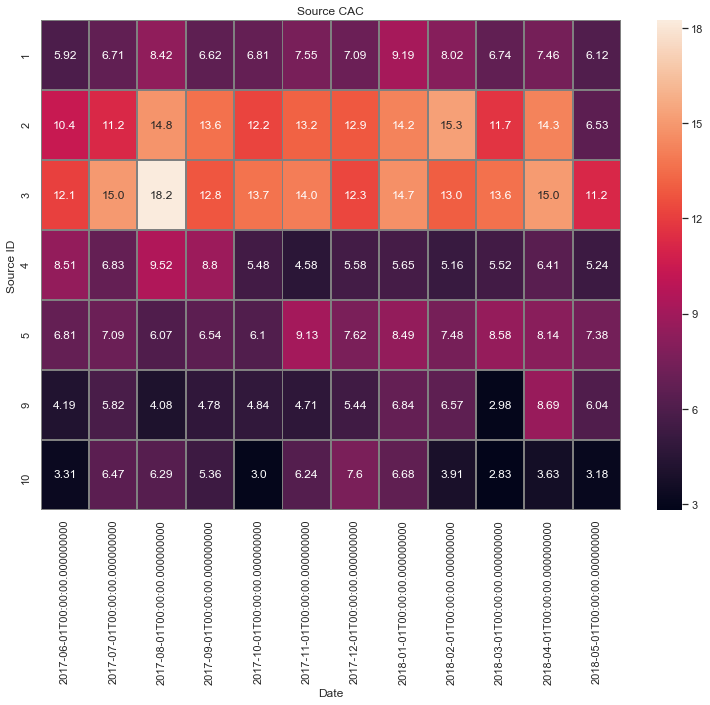

In [70]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Source CAC')
sns.heatmap(costs.pivot_table(index='source_id', columns='month', values='source_CAC', aggfunc='mean'), annot=True, fmt='.3', linewidths=1, linecolor='gray')
plt.xlabel('Date')
plt.ylabel('Source ID')
plt.show()

In [71]:
costs.pivot_table(index='source_id', columns='month', values='source_CAC', aggfunc='mean').round(2)

month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
source_id,,,,,,,,,,,,
1,5.92,6.71,8.42,6.62,6.81,7.55,7.09,9.19,8.02,6.74,7.46,6.12
2,10.37,11.22,14.84,13.63,12.23,13.15,12.86,14.24,15.27,11.70,14.26,6.53
3,12.12,15.02,18.23,12.76,13.66,14.04,12.33,14.72,13.03,13.63,15.04,11.15
4,8.51,6.83,9.52,8.80,5.48,4.58,5.58,5.65,5.16,5.52,6.41,5.24
5,6.81,7.09,6.07,6.54,6.10,9.13,7.62,8.49,7.48,8.58,8.14,7.38
9,4.19,5.82,4.08,4.78,4.84,4.71,5.44,6.84,6.57,2.98,8.69,6.04
10,3.31,6.47,6.29,5.36,3.00,6.24,7.60,6.68,3.91,2.83,3.63,3.18


Согласно полученным результатам CAC можно сказать, что маркетинг работает наиболее эффективно для каналов продвижения под номерами 9 и 10, они же являются самыми малозатратными.

#### Расчет ROMI по кагортам в разрезе источников. Сравнение окупаемости за одинаковые периоды жизни когорт.

Теперь имеются все необходимые данные для определения метрики ROMI, которая поможет ответить на вопрос об окупаемости привлечения клиентов и эффективности маркетинга в целом.

In [72]:
buyers_daily.rename(columns={'source_id':'main_source_id', 'month':'first_buy_ts_month'}, inplace=True) 

In [73]:
source_ltv = orders_extended.merge(buyers_daily, on=['main_source_id', 'first_buy_ts_month'])

In [74]:
source_ltv['age'] = (source_ltv['buy_ts_month'] - source_ltv['first_buy_ts_month']) / np.timedelta64(1, 'M')
source_ltv['age'] = source_ltv['age'].round().astype('int')
source_ltv

,buy_ts,revenue,uid,buy_ts_month,first_buy_ts_month,main_source_id,n_buyers_source,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,190,0
1,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,1,190,0
2,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01,1,190,0
3,2017-06-02 15:08:00,12.83,3644482766749211722,2017-06-01,2017-06-01,1,190,0
4,2017-06-04 13:06:00,17.11,3644482766749211722,2017-06-01,2017-06-01,1,190,0
...,...,...,...,...,...,...,...,...
50359,2018-05-31 16:06:00,4.89,14372027836561602167,2018-05-01,2018-05-01,9,60,0
50360,2018-05-31 17:20:00,3.42,13465334080837783919,2018-05-01,2018-05-01,9,60,0
50361,2018-05-31 18:22:00,0.92,5359718846599854608,2018-05-01,2018-05-01,9,60,0
50362,2018-05-31 23:40:00,1.16,13121453305610619664,2018-05-01,2018-05-01,9,60,0


In [75]:
source_ltv['source_revenue'] = source_ltv.groupby(['main_source_id', 'first_buy_ts_month', 'age'])['revenue'].transform('sum')
source_ltv['source_LTV'] = source_ltv['source_revenue'] / source_ltv['n_buyers_source']     
source_ltv.head()

,buy_ts,revenue,uid,buy_ts_month,first_buy_ts_month,main_source_id,n_buyers_source,age,source_revenue,source_LTV
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,1,190,0,1378.7,7.256316
1,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,1,190,0,1378.7,7.256316
2,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01,1,190,0,1378.7,7.256316
3,2017-06-02 15:08:00,12.83,3644482766749211722,2017-06-01,2017-06-01,1,190,0,1378.7,7.256316
4,2017-06-04 13:06:00,17.11,3644482766749211722,2017-06-01,2017-06-01,1,190,0,1378.7,7.256316


In [76]:
source_CAC = costs[['source_id', 'month', 'source_CAC']]                           
source_CAC.rename(columns={'source_id':'main_source_id', 'month':'first_buy_ts_month'}, inplace=True)
source_CAC = source_CAC.groupby(['main_source_id', 'first_buy_ts_month']).mean().reset_index()
source_CAC

,main_source_id,first_buy_ts_month,source_CAC
0,1,2017-06-01,5.924263
1,1,2017-07-01,6.705500
2,1,2017-08-01,8.423097
3,1,2017-09-01,6.616784
4,1,2017-10-01,6.811029
...,...,...,...
79,10,2018-01-01,6.677717
80,10,2018-02-01,3.909593
81,10,2018-03-01,2.830161
82,10,2018-04-01,3.628505


In [77]:
ROMI = source_CAC.merge(
    source_ltv[['main_source_id', 'first_buy_ts_month', 'age', 'source_LTV']], on=['main_source_id', 'first_buy_ts_month']
)
ROMI['ROMI'] = ROMI['source_LTV'] / ROMI['source_CAC']                  
ROMI.head()

,main_source_id,first_buy_ts_month,source_CAC,age,source_LTV,ROMI
0,1,2017-06-01,5.924263,0,7.256316,1.224847
1,1,2017-06-01,5.924263,0,7.256316,1.224847
2,1,2017-06-01,5.924263,0,7.256316,1.224847
3,1,2017-06-01,5.924263,0,7.256316,1.224847
4,1,2017-06-01,5.924263,0,7.256316,1.224847


In [78]:
output = ROMI.pivot_table(index=['main_source_id', 'first_buy_ts_month'], columns='age', values='ROMI', aggfunc='mean')
output.cumsum(axis=1).round(2) 

age                                  0     1     2     3     4     5     6   \
main_source_id first_buy_ts_month                                             
1              2017-06-01          1.22  1.59  1.97  2.60  3.32  3.67  4.10   
               2017-07-01          1.09  1.25  2.05  2.27  2.41  2.54  2.61   
               2017-08-01          0.89  1.03  1.15  1.27  1.39  1.47  1.55   
               2017-09-01          0.91  1.18  1.27  1.41  1.41  1.43  1.44   
               2017-10-01          0.88  1.04  1.07  1.13  1.14  1.16  1.18   
...                                 ...   ...   ...   ...   ...   ...   ...   
10             2018-01-01          0.46  0.47  0.48   NaN   NaN   NaN   NaN   
               2018-02-01          0.63  0.66  0.66   NaN   NaN   NaN   NaN   
               2018-03-01          1.21  1.24  1.25   NaN   NaN   NaN   NaN   
               2018-04-01          0.67   NaN   NaN   NaN   NaN   NaN   NaN   
               2018-05-01          1.15   NaN   NaN   NaN   NaN   NaN   NaN   

age                                  7     8     9     10    11  
main_source_id first_buy_ts_month                                
1              2017-06-01          4.53  4.91  5.19  5.40  5.68  
               2017-07-01          2.70  2.83  2.98  3.12   NaN  
               2017-08-01          1.86  2.13  2.22   NaN   NaN  
               2017-09-01          1.49  1.57   NaN   NaN   NaN  
               2017-10-01          1.23   NaN   NaN   NaN   NaN  
...                                 ...   ...   ...   ...   ...  
10             2018-01-01           NaN   NaN   NaN   NaN   NaN  
               2018-02-01           NaN   NaN   NaN   NaN   NaN  
               2018-03-01           NaN   NaN   NaN   NaN   NaN  
               2018-04-01           NaN   NaN   NaN   NaN   NaN  
               2018-05-01           NaN   NaN   NaN   NaN   NaN  

[84 rows x 12 columns]

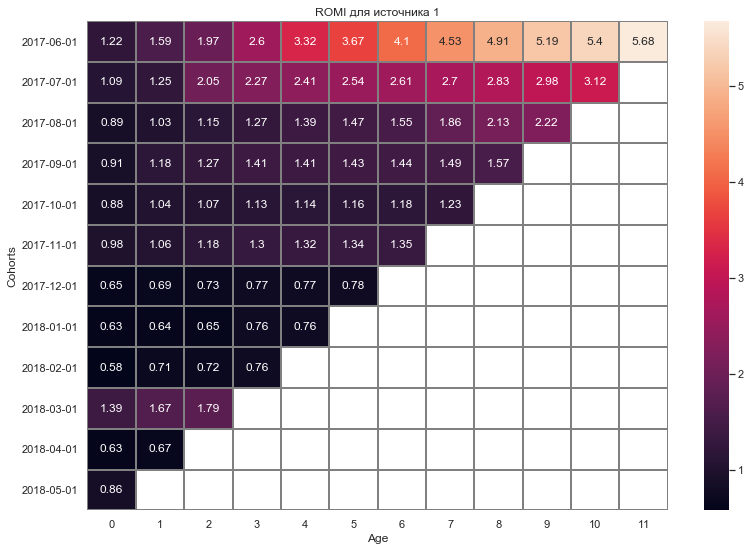

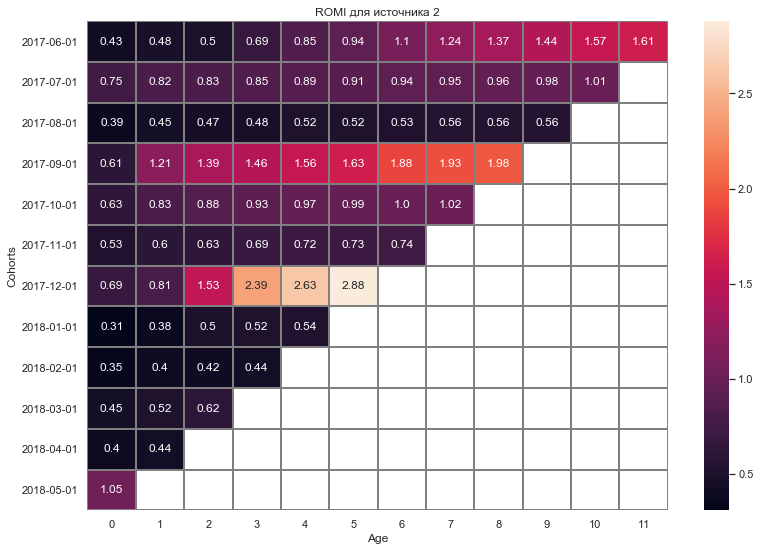

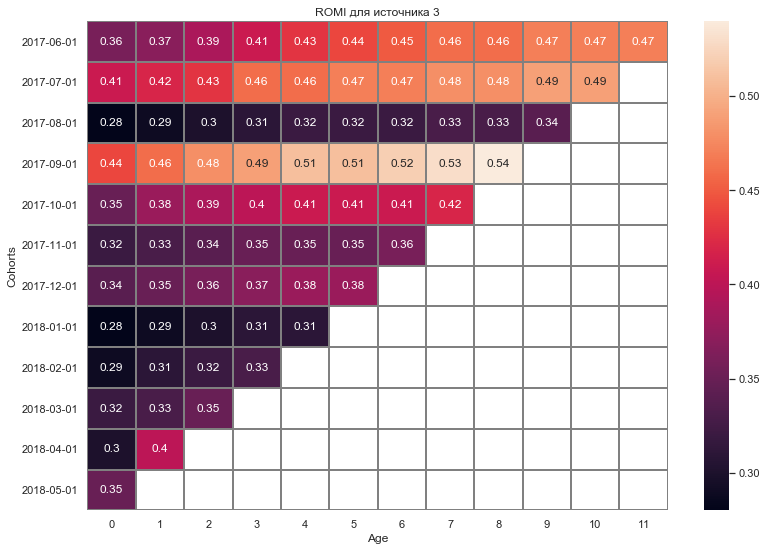

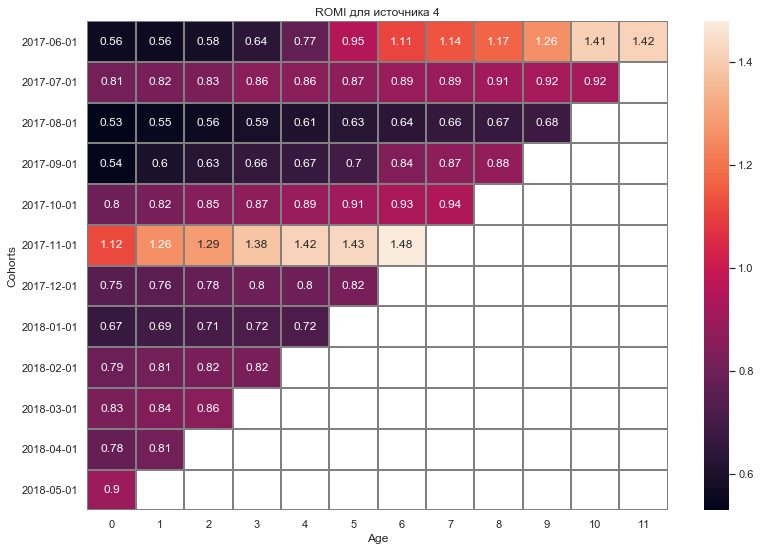

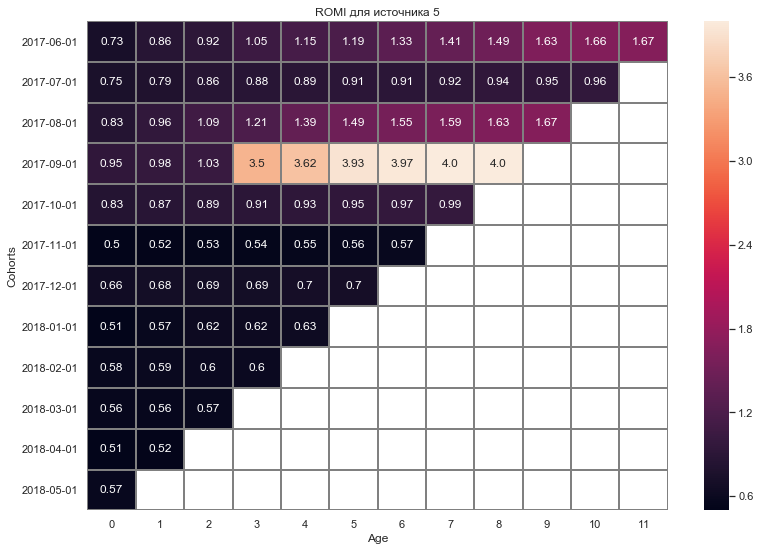

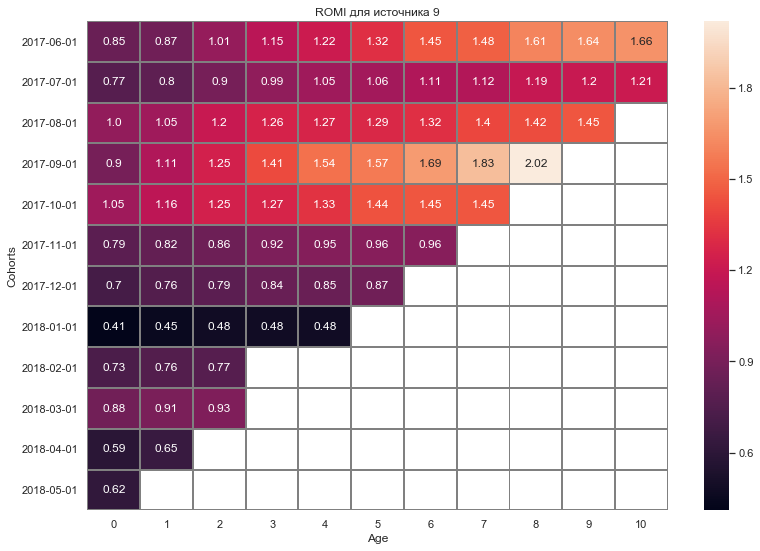

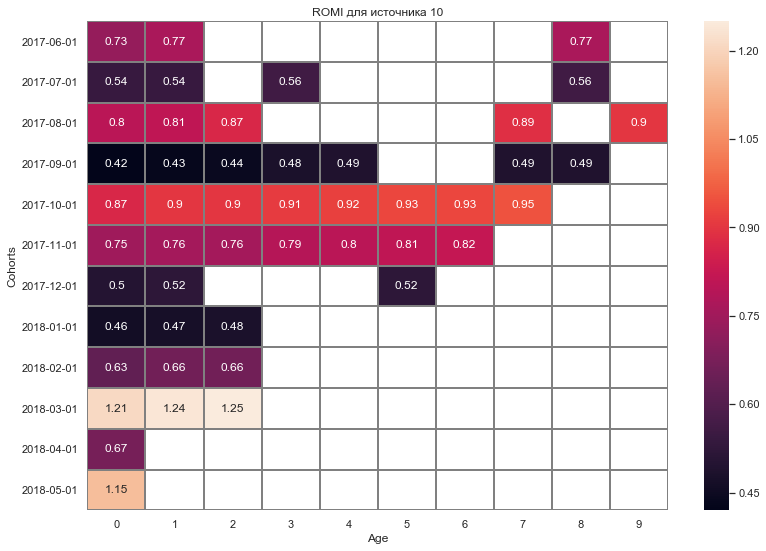

In [79]:
ROMI['first_buy_ts_month'] = ROMI['first_buy_ts_month'].astype('str')
for i in ROMI['main_source_id'].unique():
    df = ROMI[ROMI['main_source_id'] == i]
    df = df.pivot_table(index='first_buy_ts_month', columns='age', values='ROMI', aggfunc='mean')
    df = df.cumsum(axis=1).round(2)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(f'ROMI для источника {i}')
    sns.heatmap(df, annot=True, fmt='.3', linewidths=1, linecolor='gray')
    plt.xlabel('Age')
    plt.ylabel('Cohorts')
    plt.show()

#### Вывод

Маркетинговые метрики выглядят очень информативно. Персонал, занимающийся продвижением продукта проделывает огромную работу. Задействовано несколько каналов для продвижения, расходы активно изменяются и перераспределяются. График ежемесячных расходов полностью напоминает метрику DAU, что означает продуктивность рекламы. Расходы по источникам распределены очень неравномерно и показатель CAC говорит, что с точнки зрения привличения наиболее рационально бюджет используется для источников 9 и 10, и нерационально для источника 3. Однако с точки зрения окупаемости, наилучшим можно считать источник под номером 1, а плохими источниками: 3 и 10.

## Формулировка выводов и рекомендаций

### Источники трафика, на которые стоит делать упор.

На мой взгляд, самым перспективным источником трафика является источник под номером 9. Являясь самым малозатратным, он привлекает достаточное количество покупателей, чтобы оказаться одним из самых окупаемых. Так же каналы продвижения номера 1 и 5 очень хороши по показателям окупаемости затрат на маркетинг. Все эти источники трафика достойны тщательного внимания и именно на них стоит делать упор.

### Описание выводов по подсчетам вссех видов метрик.

В совокупности все расчитанные в проете метрики говорят, что сервис Яндекс.Афиша является весьма популярным. Достаточно большое количество поситителей и новых пользователей. Однако конвертация этих посетителей в покупателей могла быть лучше. При 228169 уникальных поситителей, совершают покупки только 36509, что составляет 6.25%. Но даже при такой конвертации маркетинговые затраты неплохо окупаются.

### Подведение итогов. Определение перспективных когорт.

По имеющимся данным был произведен когортный анализ продуктовых, коммерческих и маркетинговых метрик. По итогам расчетов можно выделить наиболее перспективные когорты покупателей, с целью улучшения последующих продаж. К наиболее перспективным когортам относятся: июньская, июльская, августовская и сентябрьская когорты. У них самые лучшие показатели Retention Rate, самый высокий LTV даже с учетом дольшей продолжительности существования, а еще все эти когорты достаточно быстро окупились.